<!DOCTYPE html>
<html lang="en">
<head>
    <style>
        @import url('https://fonts.googleapis.com/css2?family=Lexend:wght@400;700&display=swap');
        @font-face {
            font-family: 'Menlo Nerd';
            src: url('path/to/menlo-nerd-font.woff2') format('woff2');
        }
        body {
            font-family: 'Lexend', sans-serif;
        }
        code, pre {
            font-family: 'Menlo Nerd', monospace;
        }
    </style>
</head>
<body>
</body>
</html>

# Clarity with Data: Logistics Decision Making under Risk Part 2

## Simulating Disruption and Predicting Impact: Quantifying Supply Chain Risk Exposure

In our previous post, we explored the importance of balancing cost and risk in supply chain optimization. We introduced a use case involving a Midwest valve manufacturer facing potential hurricane threats to its coastal suppliers. We walked through the initial steps of building a supply chain model, including defining the scope, bootstrapping the logistics network with OpenStreetMap data, and simulating a basic supplier network. In this post we will continue the example and show how simulation can be used to understand the operational and financial impacts of disruptions on the supply chain. As in previous posts, we will show our work with full implementations in code.

## Problem Framing
**Problem**: Natural disasters like hurricanes can significantly disrupt supply chains, leading to delays, production downtimes, and financial losses.

**Solution**: By simulating the impact of hurricanes on a supply chain network, we can estimate key performance indicators (KPIs) such as delivery delays, production downtimes, and financial losses. This simulation helps in understanding the potential risks and preparing mitigation strategies.

**Benefit**: Organizations can use these insights to enhance their resilience against natural disasters, minimize disruptions, and reduce financial losses.

## Simulation Code and Analysis

The following sections contain the code and analysis for simulating the impact of hurricanes on a supply chain network.


### Refactoring Previous Code for Simplicity and Clarity

To enhance the clarity and maintainability of our code, we've refactored the functionalities from the previous post into reusable libraries. This modular approach not only simplifies the code but also promotes better organization and readability.

Here's a glimpse of the refactored code:

#### Import Libraries

In [107]:
import sys
import os
import json
import logging
import random
import math
import statistics
import networkx as nx
from joblib import Parallel, delayed
from scipy.spatial.distance import euclidean
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import copy
from matplotlib.ticker import FuncFormatter

# Enable interactive plots
%matplotlib inline

# Add the root directory to the Python path
script_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(script_dir, ".."))
sys.path.append(project_root)

try:
    from supplychain.simulation import build_supply_chain_from_config, simulate_supply_chain
    from supplychain.visualization import visualize_supply_chain, assign_supplier_types
except ImportError as e:
    logging.error(f"Error importing modules: {e}")
    raise



#### Configure Logging

In [17]:

# Remove all handlers associated with the root logger object
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging
logging.basicConfig(
    level=logging.ERROR, format="%(asctime)s - %(levelname)s - %(message)s"
)

logging.info("Build supply chain from a configuration file")
config_filepath = os.path.join(project_root, "notebooks", "sim_config.json")
combined_graph_filepath = os.path.join(
    project_root, "combined_graph.graphml"
)  # Path to the GraphML file
visualization_filepath = os.path.join(project_root, "supply_chain_graph.html")

# Check if config file exists
if not os.path.exists(config_filepath):
    logging.error(f"Configuration file not found: {config_filepath}")
    sys.exit(1)

# Load configuration
with open(config_filepath, "r") as f:
    config = json.load(f)

G, road_networks = build_supply_chain_from_config(
    config_filepath, combined_graph_filepath
)


#### Create the Supply Chain

In [124]:
logging.info("Simulate the supply chain")

# Assign supplier types to locations
locations_with_suppliers = assign_supplier_types(
    config["locations"], config["supplier_types"]
)

# Visualize the graph
visualize_supply_chain(
    G, locations_with_suppliers, config["color_map"], visualization_filepath
)


This refactoring allows us to focus on the core aspects of simulating disruptions and analyzing their impact, without getting bogged down in the complexities of building the initial network.

Now, we'll delve deeper into simulating disruptions and predicting their impact on key performance indicators (KPIs). This will enable the valve manufacturer to proactively identify vulnerabilities and develop effective mitigation strategies.

### Step 4: Simulate Disruption Events and Their Impact

This step involves simulating various disruption scenarios and quantifying their potential impact on the supply chain. We will focus on hurricane events and their effects on transportation routes.

Now, we'll delve deeper into simulating disruptions and predicting their impact on key performance indicators (KPIs). This will enable the valve manufacturer to proactively identify vulnerabilities and develop effective mitigation strategies.

**Objectives:**

* **Simulate Hurricane Events:**  Model hurricane events with varying intensities and paths, affecting different parts of the coastal supplier regions.
* **Disrupt Transportation Routes:** Simulate the disruption of transportation routes based on hurricane intensity and proximity to the affected areas.
* **Calculate Disruption Impact:**  Quantify the impact of disruptions on KPIs such as delivery delays, production downtime, and potential financial losses.

**Steps:**

1. **Define Hurricane Parameters:** Define parameters like hurricane intensity (e.g., categories 1-5), size, and path.
2. **Simulate Hurricane Impact:**  Develop a function to simulate the impact of a hurricane on the transportation network. This function should consider the hurricane parameters and the proximity of transportation routes to the hurricane's path.  The function could, for example, assign a probability of disruption to each route based on the hurricane's intensity and distance.
3. **Calculate KPIs:**  Develop functions to calculate the impact of disruptions on KPIs. For instance:
    * **Delivery Delays:** Calculate the increase in transportation time due to disrupted routes.
    * **Production Downtime:** Estimate the potential downtime at the Wausau plant due to delayed deliveries of critical components.
    * **Financial Losses:**  Estimate potential financial losses due to production downtime, expedited shipping costs, or lost sales.


#### Define the Huricane Simulation Parameters

In [ ]:
def define_hurricane_parameters():
    hurricane_intensity = random.randint(1, 5)
    hurricane_size = random.randint(50, 200)  # km
    
    # Generate a random hurricane path
    start_lat = 44.0 + random.uniform(-1, 1)
    start_lon = -88.0 + random.uniform(-1, 1)
    path_length = random.randint(3, 5)
    hurricane_path = [(start_lat + i * random.uniform(-0.5, 0.5), start_lon + i * random.uniform(-0.5, 0.5)) for i in range(path_length)]
    
    return hurricane_intensity, hurricane_size, hurricane_path


#### Calculate the Impact of the Hurrican on the Supply Chain

In [115]:
def simulate_hurricane_impact(graph, hurricane_intensity, hurricane_size, hurricane_path):
    disrupted_edges = []
    for u, v, key, data in graph.edges(data=True, keys=True):
        # Calculate the distance of the edge from the hurricane path
        edge_coords = [(graph.nodes[u]['y'], graph.nodes[u]['x']), (graph.nodes[v]['y'], graph.nodes[v]['x'])]
        min_distance = min([euclidean(edge_coords[0], point) for point in hurricane_path] +
                           [euclidean(edge_coords[1], point) for point in hurricane_path])
        
        # Assign a probability of disruption based on hurricane intensity and distance
        # Adjusted disruption probability with a scaling factor
        scaling_factor = 0.1  # Adjust this factor to control the probability
        disruption_probability = min(1.0, scaling_factor * hurricane_intensity / 5 * (hurricane_size / (min_distance + 1)))
        if random.random() < disruption_probability:
            disrupted_edges.append((u, v, key))
    
    return disrupted_edges

def calculate_delivery_delay(graph, disrupted_edges):
    total_delay = 0
    for u, v, key in disrupted_edges:
        # Estimate delay based on edge length and a fixed delay factor
        edge_length = graph.edges[u, v, key]['length'] 
        delay = edge_length / 1000 / 100  # Convert meters to hours assuming average speed
        total_delay += delay
    return total_delay

def calculate_kpis(graph, disrupted_edges):
    delivery_delay = calculate_delivery_delay(graph, disrupted_edges)
    production_downtime = delivery_delay * 0.5  # Example factor
    financial_losses = production_downtime * 10000  # Example cost per hour of downtime
    return delivery_delay, production_downtime, financial_losses


#### Run the Disruption Impact Simulation

In [116]:

def run_single_simulation(graph):
    graph_copy = copy.deepcopy(graph)  # Create an independent copy of the graph
    hurricane_intensity, hurricane_size, hurricane_path = define_hurricane_parameters()
    disrupted_edges = simulate_hurricane_impact(graph_copy, hurricane_intensity, hurricane_size, hurricane_path)
    delivery_delay, production_downtime, financial_loss = calculate_kpis(graph_copy, disrupted_edges)
    return hurricane_intensity, hurricane_size, delivery_delay, production_downtime, financial_loss

def run_simulation(graph, num_simulations=1000):
    results = Parallel(n_jobs=-1)(delayed(run_single_simulation)(graph) for _ in range(num_simulations))
    
    intensities, sizes, delivery_delays, production_downtimes, financial_losses = zip(*results)
    
    return intensities, sizes, delivery_delays, production_downtimes, financial_losses


In [117]:
num_simulations = 100
intensities, sizes, delivery_delays, production_downtimes, financial_losses = run_simulation(G, num_simulations)


### Step 5: Visualize and Analyze the Results
Visualizing the simulation results is crucial for understanding the impact of disruptions and communicating findings effectively.

#### Objectives:

- **Visualize KPI Impact**: Create visualizations to show the impact of disruptions on KPIs like delivery delays, production downtime, and ultimately financial loss.
- **Analyze Scenarios**: Compare the impact of different hurricane scenarios (e.g., varying intensities and paths) on the supply chain.

Hurricane Intensity: Mean: 2.92, Std Dev: 1.33, 5th: 1.00, Median: 3.00, Mode: 2, 95th: 5.00
Hurricane Size: Mean: 123.54, Std Dev: 43.22, 5th: 61.00, Median: 122.50, 95th: 191.10
Delivery Delay: Mean: 923.32 hours, Std Dev: 307.03 hours, 5th: 422.99 hours, Median: 946.37 hours, 95th: 1,386.39 hours
Production Downtime: Mean: 461.66 hours, Std Dev: 153.52 hours, 5th: 211.50 hours, Median: 473.18 hours, 95th: 693.20 hours
Financial Loss: Mean: $4,616,578.47, Std Dev: $1,535,171.53, 5th: $2,114,962.19, Median: $4,731,848.19, 95th: $6,931,954.41


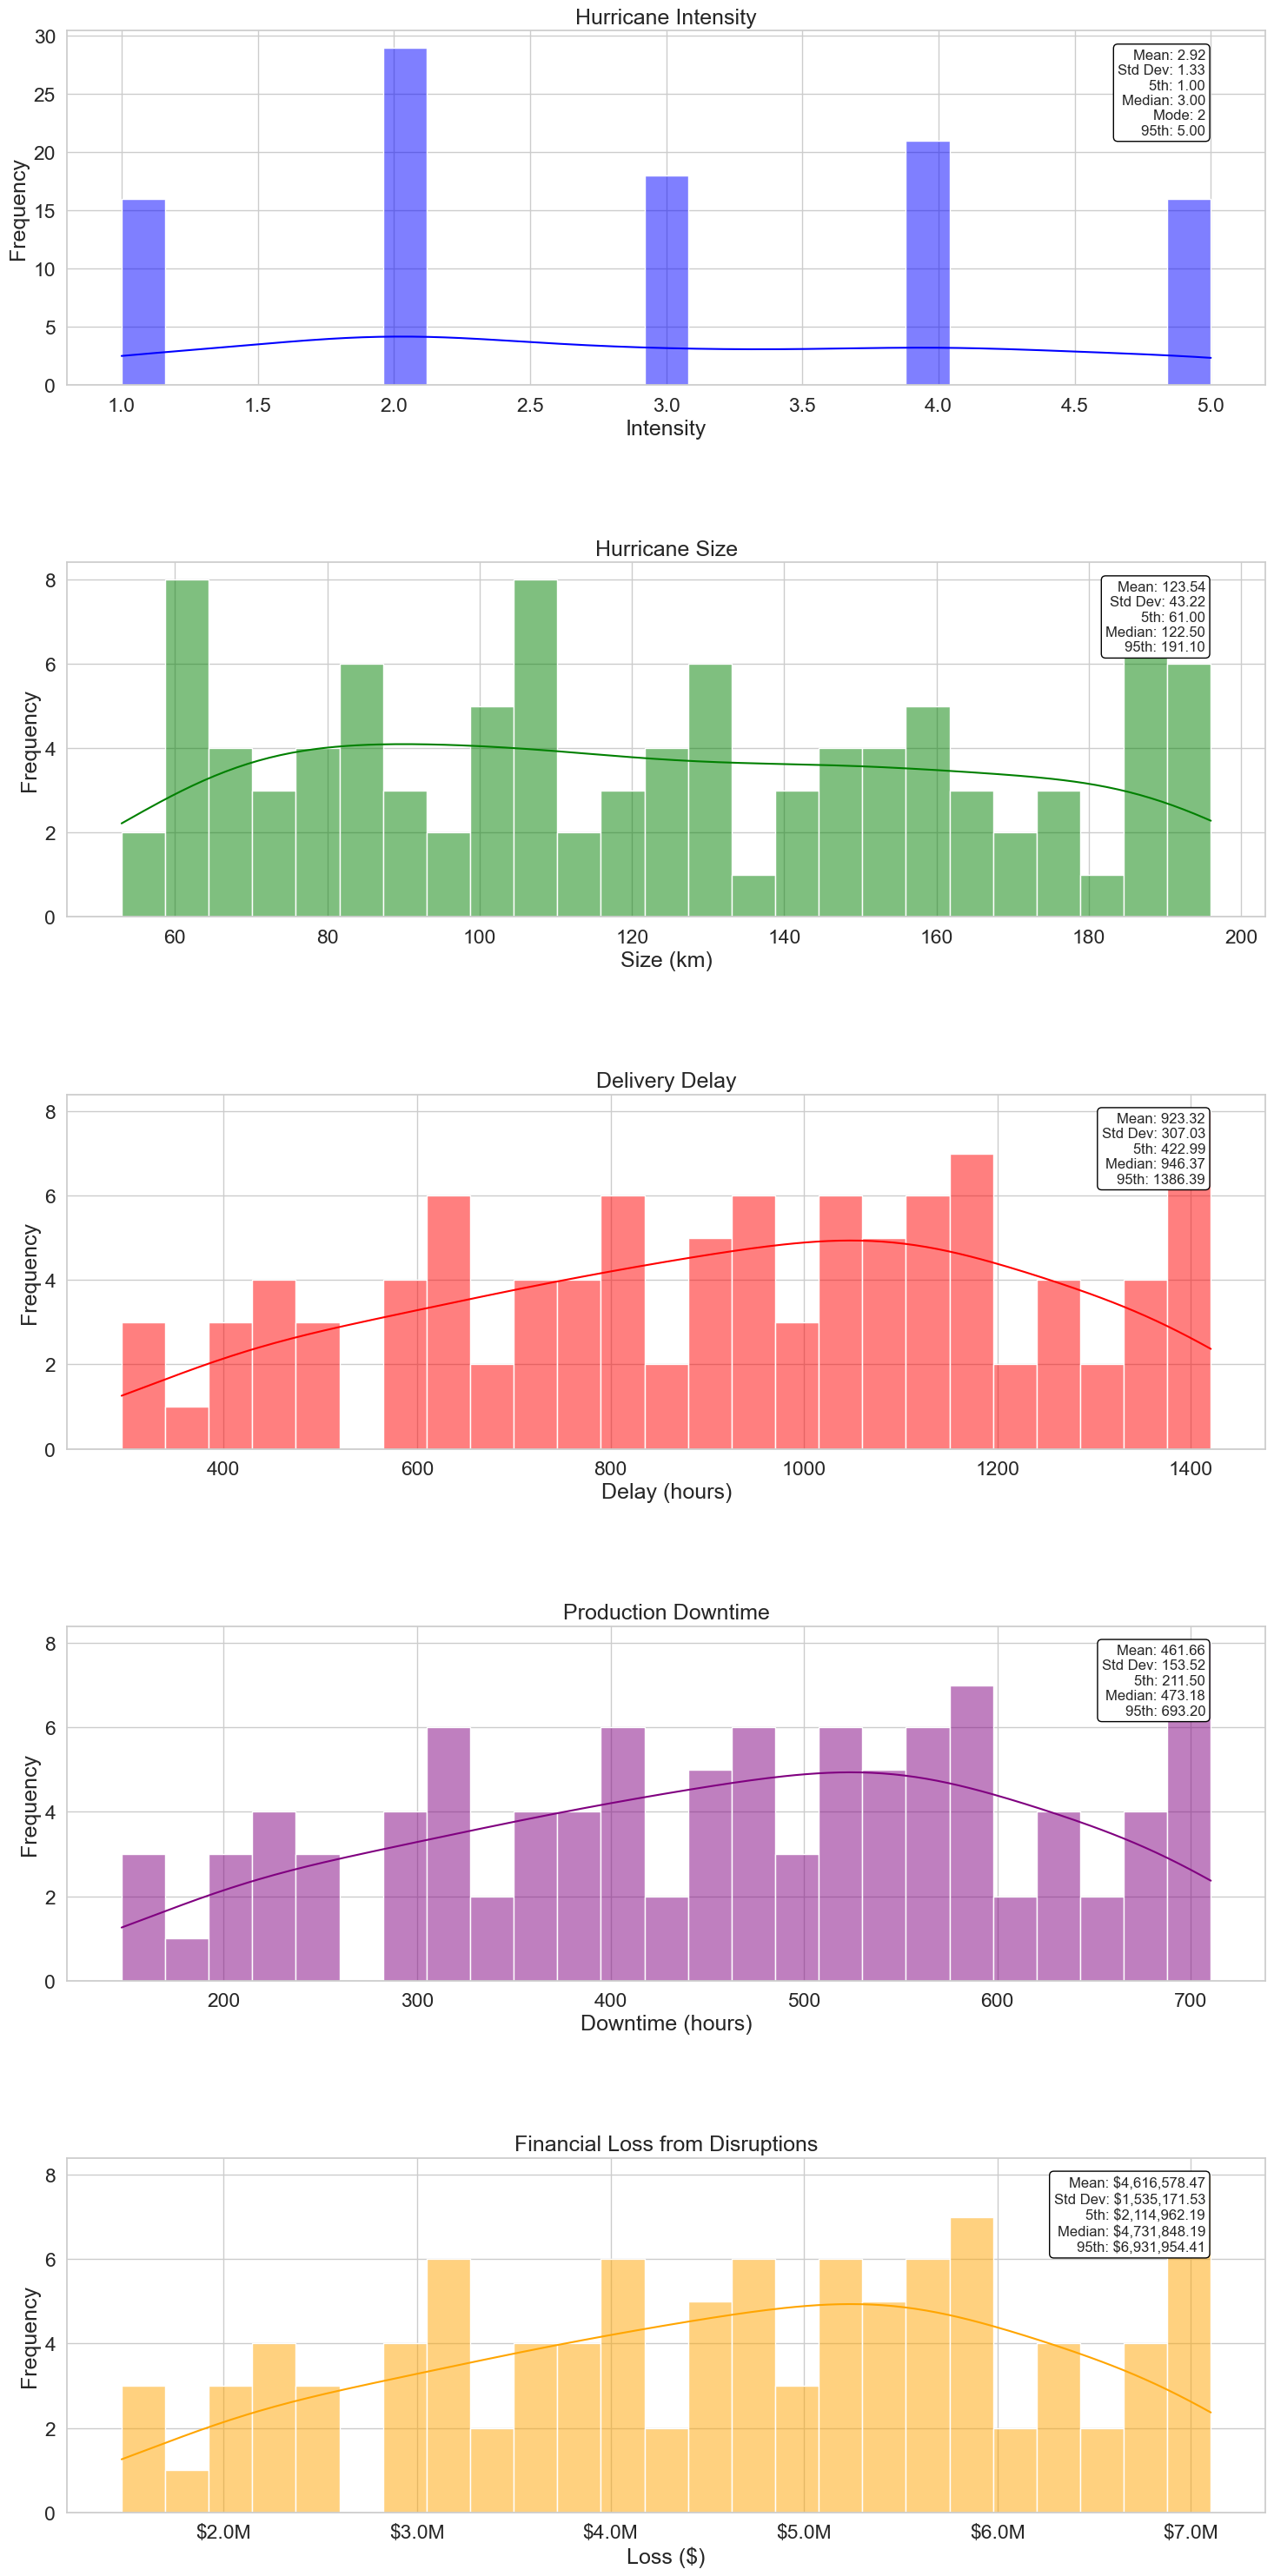

In [123]:
def calculate_statistics(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    quantiles = np.percentile(data, [5, 50, 95])
    median = np.median(data)
    try:
        mode = statistics.mode(data)
    except statistics.StatisticsError:
        mode = None  # In case there's no unique mode
    return mean, std_dev, quantiles, median, mode

# Calculate statistics
intensity_stats = calculate_statistics(intensities)
size_stats = calculate_statistics(sizes)
delivery_delay_stats = calculate_statistics(delivery_delays)
production_downtime_stats = calculate_statistics(production_downtimes)
financial_loss_stats = calculate_statistics(financial_losses)

# Print the statistics
print(f"Hurricane Intensity: Mean: {intensity_stats[0]:,.2f}, Std Dev: {intensity_stats[1]:,.2f}, 5th: {intensity_stats[2][0]:,.2f}, Median: {intensity_stats[3]:,.2f}, Mode: {intensity_stats[4]}, 95th: {intensity_stats[2][2]:,.2f}")
print(f"Hurricane Size: Mean: {size_stats[0]:,.2f}, Std Dev: {size_stats[1]:,.2f}, 5th: {size_stats[2][0]:,.2f}, Median: {size_stats[3]:,.2f}, 95th: {size_stats[2][2]:,.2f}")
print(f"Delivery Delay: Mean: {delivery_delay_stats[0]:,.2f} hours, Std Dev: {delivery_delay_stats[1]:,.2f} hours, 5th: {delivery_delay_stats[2][0]:,.2f} hours, Median: {delivery_delay_stats[3]:,.2f} hours, 95th: {delivery_delay_stats[2][2]:,.2f} hours")
print(f"Production Downtime: Mean: {production_downtime_stats[0]:,.2f} hours, Std Dev: {production_downtime_stats[1]:,.2f} hours, 5th: {production_downtime_stats[2][0]:,.2f} hours, Median: {production_downtime_stats[3]:,.2f} hours, 95th: {production_downtime_stats[2][2]:,.2f} hours")
print(f"Financial Loss: Mean: ${financial_loss_stats[0]:,.2f}, Std Dev: ${financial_loss_stats[1]:,.2f}, 5th: ${financial_loss_stats[2][0]:,.2f}, Median: ${financial_loss_stats[3]:,.2f}, 95th: ${financial_loss_stats[2][2]:,.2f}")
# Function to format the financial loss axis
def millions(x, pos):
    'The two args are the value and tick position'
    return f'${x*1e-6:.1f}M'

# Increase font size
sns.set(style="whitegrid", font_scale=1.5)


# Display results in seaborn plots
fig, axes = plt.subplots(5, 1, figsize=(15, 30))  # 5 rows, 1 column

# Plot Hurricane Intensity
sns.histplot(intensities, bins=25, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Hurricane Intensity')
axes[0].set_xlabel('Intensity')
axes[0].set_ylabel('Frequency')
axes[0].annotate(f'Mean: {intensity_stats[0]:.2f}\nStd Dev: {intensity_stats[1]:.2f}\n5th: {intensity_stats[2][0]:.2f}\nMedian: {intensity_stats[3]:.2f}\nMode: {intensity_stats[4]}\n95th: {intensity_stats[2][2]:.2f}',
                 xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Plot Hurricane Size
sns.histplot(sizes, bins=25, kde=True, color='green', ax=axes[1])
axes[1].set_title('Hurricane Size')
axes[1].set_xlabel('Size (km)')
axes[1].set_ylabel('Frequency')
axes[1].annotate(f'Mean: {size_stats[0]:.2f}\nStd Dev: {size_stats[1]:.2f}\n5th: {size_stats[2][0]:.2f}\nMedian: {size_stats[3]:.2f}\n95th: {size_stats[2][2]:.2f}',
                 xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Plot Delivery Delay
sns.histplot(delivery_delays, bins=25, kde=True, color='red', ax=axes[2])
axes[2].set_title('Delivery Delay')
axes[2].set_xlabel('Delay (hours)')
axes[2].set_ylabel('Frequency')
axes[2].annotate(f'Mean: {delivery_delay_stats[0]:.2f}\nStd Dev: {delivery_delay_stats[1]:.2f}\n5th: {delivery_delay_stats[2][0]:.2f}\nMedian: {delivery_delay_stats[3]:.2f}\n95th: {delivery_delay_stats[2][2]:.2f}',
                 xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Plot Production Downtime
sns.histplot(production_downtimes, bins=25, kde=True, color='purple', ax=axes[3])
axes[3].set_title('Production Downtime')
axes[3].set_xlabel('Downtime (hours)')
axes[3].set_ylabel('Frequency')
axes[3].annotate(f'Mean: {production_downtime_stats[0]:.2f}\nStd Dev: {production_downtime_stats[1]:.2f}\n5th: {production_downtime_stats[2][0]:.2f}\nMedian: {production_downtime_stats[3]:,.2f}\n95th: {production_downtime_stats[2][2]:.2f}',
                 xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Plot Financial Loss
sns.histplot(financial_losses, bins=25, kde=True, color='orange', ax=axes[4])
axes[4].set_title('Financial Loss from Disruptions')
axes[4].set_xlabel('Loss ($)')
axes[4].set_ylabel('Frequency')
axes[4].xaxis.set_major_formatter(FuncFormatter(millions))
axes[4].annotate(f'Mean: ${financial_loss_stats[0]:,.2f}\nStd Dev: ${financial_loss_stats[1]:,.2f}\n5th: ${financial_loss_stats[2][0]:,.2f}\nMedian: ${financial_loss_stats[3]:,.2f}\n95th: ${financial_loss_stats[2][2]:,.2f}',
                 xy=(0.95, 0.95), xycoords='axes fraction', fontsize=12, ha='right', va='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Adjust layout with increased spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase the height space between plots
plt.show()


## What should we do next?

Based on the insights gained from the simulation, organizations should:

1. **Develop Mitigation Strategies**: Create plans to mitigate the impact of hurricanes on supply chains, such as diversifying suppliers, increasing inventory levels, and improving logistics.
2. **Enhance Resilience**: Implement measures to enhance the resilience of supply chains, such as strengthening infrastructure and improving communication channels.
3. **Continuous Monitoring**: Continuously monitor the supply chain network and update the simulation model with new data to ensure preparedness for future natural disasters.


## Conclusion
By simulating disruptions and quantifying their impact, the valve manufacturer can gain valuable insights into its supply chain vulnerabilities. This information empowers the company to make data-driven decisions, develop effective mitigation strategies, and build a more resilient supply chain.

In the next installment of this series, we will explore how to leverage these insights to optimize the supply chain for resilience, considering factors like alternative sourcing, inventory management, and flexible transportation options. Stay tuned!